# Backpropagation Project





In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier as BackProp
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from scipy.stats import bernoulli
import copy

In [ ]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
f = lambda a: a * (1-a)

In [ ]:
class MLPClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None, validation=False):
        """ Initializes class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent
            validation(float): The decimal percentage of validation split. 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes.
        Example:
            mlp = MLPClassifier(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.validation = validation


    def fit(self, X, y, deterministic, X_val=None, y_val=None, mse = False, score = False, act_coeff = .85):
        """ Fits the data; runs the algorithm and adjusts the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: Allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        self.X = X
        self.y = y

        input_dim = len(X[0])           # gets the number of nodes in the input layer
        output_dim = len(np.unique(y))  # gets the number of unique classes
        if mse:
          mse_val = []
          mse_train = []
        
        if score:
          s_val = []
          s_train = []

        # One-hot encoding
        self.classes = np.unique(y)
        
        self.class_index = {}
        for i, val in enumerate(self.classes):
          self.class_index[val] = i
        
        y = np.array([self.class_index[y[i]] for i in range(len(y))])
        if y_val is not None:
          y_val = np.array([self.class_index[y_val[i]] for i in range(len(y_val))])

        if self.hidden_layer_widths == None:              # if none set to double input 
          dims = [input_dim,  2 * input_dim, output_dim]  # keeps track of dimensions of each layer
        
        else:
          dims = [input_dim]                    # keeps track of dimensions of each layer
          for h in self.hidden_layer_widths:
            dims.append(h)
          dims.append(output_dim)
        
        self.num_layers = len(dims)     # number of layers
        weights = []                    # weights
        prev_wc = []                    # keeps track of change of weights for momentum

        for i in range(self.num_layers - 1):
          w = np.zeros((dims[i+1], dims[i]+1))  # adding dimensions for each layer, +1 is for bias
          weights.append(w)
          prev_wc.append(np.copy(w))

        X = np.column_stack((X, np.ones(len(X))))   # updating X to have a column of all ones for bias

      
        num_epochs = 0
        val_acc = 0
        while num_epochs < deterministic: 
          total_change = 0  # keeps track of total change in weights
          num_epochs += 1
          if self.shuffle:
            X, y = self._shuffle_data(X, y)

          for x, t in zip(X, y):
            # calculating output steps
            a_vals = [x]                                  # keeps track of 'a' values, feeding in input
            for l in range(self.num_layers - 1):               # for each of our layers (excluding output layer)                    
              a = sigmoid(a_vals[l]@weights[l].T)         # gets 'a' values, passing through sigmoid
               
              if l != self.num_layers - 2: 
                a = np.append(a, 1.)                     # adding bias

              a_vals.append(np.array(a))                 # adding to our a_values

            # backpropagation steps
            delta = []  # keeps track of all delta values

            # finding first delta
            # for second-last layer <- last layer 
            delt = []
     
            z = np.zeros(len(self.classes))   # number of classes array with 1 in class ex. y = 0 z = [1, 0, 0]

            z[int(t)] = 1
            delt_out = (z - a_vals[-1])* a_vals[-1] * (1- a_vals[-1])   # first delta value
            delta.append(delt_out)

            #finding the deltas
            for l in range(1, self.num_layers - 1):                                  # -1 because don't need deltas for layer 1
              delt_layer = []
              for i in range(len(weights[-l][0]) - 1):                          # -1 because don't need one for bias
                delt_j = np.sum(delt_out*weights[-l][:,i])*f(a_vals[-l-1][i])   # calculating the delta j's
                delt_layer.append(delt_j)
              delta.append(delt_layer)

            for l in range(1, self.num_layers):
              for i in range(dims[-l-1] + 1):     
                for j in range(len(delta[l-1])): 
                  delt_w = np.copy(self.lr * a_vals[-l-1][i] * delta[l-1][j] + (self.momentum * prev_wc[-l][j][i]))   # change of weight  
                  
                  weights[-l][j][i] += delt_w

                  prev_wc[-l][j][i] = np.copy(delt_w)   # updating weight change to previous weight change matrix
          
          self.weights = weights

          if mse:   # calculating MSE
            mse_val.append(self.MSE(X_val, y_val))
            mse_train.append(self.MSE(X, y, full_X = True))

          if score:   # calculating Score
            s_val.append(self.score(X_val, y_val))
            s_train.append(self.score(X, y, full_X = True))

          if self.validation:
            
            val_acc = self.score(X_val, y_val)
            if val_acc >= act_coeff:
              if mse:
                self.mse_val = mse_val
                self.mse_train = mse_train
                self.num_epochs = num_epochs
              if score:
                self.s_val = s_val
                self.s_train = s_train

              return self
          

        if mse:
          self.mse_val = mse_val
          self.mse_train = mse_train
          self.num_epochs = num_epochs
        if score:
          self.s_val = s_val
          self.s_train = s_train

        self.weights = weights
        self.num_epochs = num_epochs
        return self



    def predict(self, X, full_X = False):
        """ Predicts all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        if full_X:
          pass
        else:
          X = np.column_stack((X, np.ones(len(X))))   # updating X to have a column of all ones for bias
        y = []

        num_layers = self.num_layers

        weights = self.weights 
        
        for x in X:
          a = sigmoid(x@self.weights[0].T)
          a = np.append(a, 1)

          for l in range(1, num_layers - 1):
            a = sigmoid(a@weights[l].T)
            if l != num_layers - 2:
              a = np.append(a, 1)
          
          y.append(np.argmax(a))
        
        return y
            

    def score(self, X, y, full_X = False, format_y = False):
        """ Returns accuracy of model on a given dataset.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        if X is None:
          return 0
        if format_y:
          y = np.array([self.class_index[y[i]] for i in range(len(y))])
        y = np.array(y, dtype = 'int32')  
        z = self.predict(X, full_X)               # model predictions
        
        c = len(z)
        cor = 0

        for i in range(c):
          if y[i] == z[i]:
            cor += 1
        return cor/c
        
    
    def MSE(self, X, y, full_X = False):
      """Calculates the Mean Squared Error.
        
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            MSE : float
                Mean Squared Error of self.predict(X) wrt. y.
      """
      z = np.array(self.predict(X, full_X))
      y = np.array(y)

      return np.sum([(y_val - z_val)**2 for y_val,z_val in zip(y, z)])/len(y)



    def _shuffle_data(self, X, y):
        """ Shuffles the data! This method should only be called internally.
            
            Args:
              X (array-like): A 2D numpy array with data, excluding targets
              y (array-like): A 2D numpy array with targets

            Returns:
              X (array-like): A 2D numpy array with data, excluding targets
              y (array-like): A 2D numpy array with targets
        """
        X = X[:,:-1]                                          #removing bias  

        com = np.column_stack((X,y))                          #stacking the data into two columns
        np.random.shuffle(com)                                #randomly shuffling
        X = np.array(com[:,:len(X[0])], dtype = 'float64')
        X = np.column_stack((X, np.ones(len(X))))             #updating X to have a column of all ones for bias

        y = com[:,-1]

        return X, y     #returning X, y

    def train_validation(X, y):
      # Making validation set
      X_val = []
      y_val = []
      X_train = []
      y_train = []

      for i in range(len(y)):
          if bernoulli.rvs(self.validation):
            X_val.append(X[i])
            y_val.append(y[i])
          else:
            X_train.append(X[i])
            y_train.append(y[i])
      
      X = X_train
      y = y_train

    def get_weights(self):
      """ Returns the weights. Used in Debugging."""
        return self.weights


In [ ]:
# iris Classification
"""
Y Values
0 - Iris-setosa
1 - Iris-versicolor
2 - Iris-virginica
"""

# load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff
eval_data = arff.loadarff('iris.arff')
eval_data = np.array(eval_data[0])

Xi = []  # 2d numpy array of X values
yi = []  # numpy array of y values, binary output
Xi_val = []
yi_val = []
Xi_test = []   # 2d numpy array of X values for test values
yi_test = []   # numpy array of y values for test values

# item in the dataset
for d in eval_data:

  # training set
  if bernoulli.rvs(.8):
    # validation set
    if bernoulli.rvs(.15):
      x_data = []
      for i in range(len(d) - 1):
        x_data.append(d[i])
      Xi_val.append(np.array(x_data))
      yi_val.append(d[-1])
    
    else:
      x_data = []
      for i in range(len(d) - 1):
        x_data.append(d[i])
      Xi.append(np.array(x_data))
      yi.append(d[-1]) 

  # test set
  else:
    x_data = []
    for i in range(len(d) - 1):
      x_data.append(d[i])

    Xi_test.append(np.array(x_data))
    yi_test.append(d[-1])

classes = np.unique(yi_val)
class_index = {}
for i, val in enumerate(classes):
  class_index[val] = i

yi_val_hot = []
for i in range(len(yi_val)):
  yi_val_hot.append(class_index[yi_val[i]])

yitest_hot = []
for i in range(len(yi_test)):
  yitest_hot.append(class_index[yi_test[i]])


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  66238      0 --:--:-- --:--:-- --:--:-- 66238


In [ ]:
M =  MLPClassifier(momentum = .5, shuffle=True, validation=True)

# train on debug data
max_iterations = 5000
M.fit(Xi,yi, max_iterations, Xi_val, yi_val, mse = True, score = True, act_coeff = .95)

MLPClassifier(hidden_layer_widths=None, lr=0.1, momentum=0.5, shuffle=True,
              validation=True)

In [ ]:
print('Testing set accuracy:', M.score(Xi_test, yitest_hot))

Testing set accuracy: 0.9142857142857143


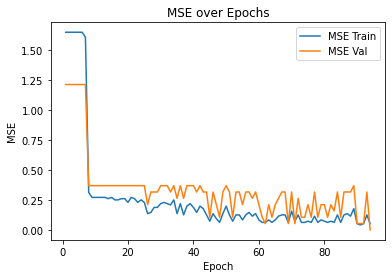

In [ ]:
m = np.linspace(1, M.num_epochs, M.num_epochs)
plt.plot(m, M.mse_train, label = "MSE Train")
plt.plot(m, M.mse_val, label = "MSE Val")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE over Epochs')
plt.legend()
plt.show()

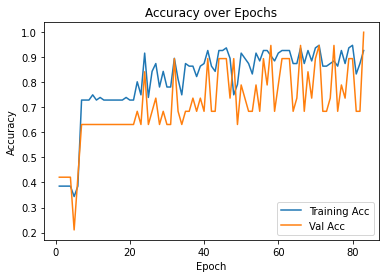

In [ ]:
plt.plot(m, M.s_train, label = 'Training Acc')
plt.plot(m, M.s_val, label = 'Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
M.score(Xi_val, yi_val, format_y = True)

1.0

In [ ]:
# train on each dataset
# load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel.arff
train_data = arff.loadarff('vowel.arff')
train_data = np.array(train_data[0])

Xv = []  # 2d numpy array of X values
yv = []  # numpy array of y values, binary output
Xv_val = []
yv_val = []
Xv_test = []   # 2d numpy array of X values for test values
yv_test = []   # numpy array of y values for test values

#item in the dataset
for d in train_data:
  if bernoulli.rvs(.8):
  # validation set
    if bernoulli.rvs(.15):
      Xv_val.append(np.array((d[3], d[4], d[5], d[6], d[7], d[8], d[9], d[10], d[11], d[12])))
      yv_val.append(d[13])
    else:
      Xv.append(np.array((d[3], d[4], d[5], d[6], d[7], d[8], d[9], d[10], d[11], d[12])))
      yv.append(d[13])     
  else:
    Xv_test.append(np.array((d[3], d[4], d[5], d[6], d[7], d[8], d[9], d[10], d[11], d[12])))
    yv_test.append(d[13])


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0  1190k      0 --:--:-- --:--:-- --:--:-- 1190k


'\nclasses = np.unique(yv_val)\nclass_index = {}\nfor i, val in enumerate(classes):\n  class_index[val] = i\n\nyv_hot = []\nfor i in range(len(yv)):\n  yv_hot.append(class_index[yv[i]])\n\n\nyv_val_hot = []\nfor i in range(len(yv_val)):\n  yv_val_hot.append(class_index[yv_val[i]])\n\nyvtest_hot = []\nfor i in range(len(yv_test)):\n  yvtest_hot.append(class_index[yv_test[i]])\n'

In [ ]:
"""NOTE TO SELF: DON'T RERUN TAKES A LONG TIME."""
lr = [.2, .15, .55, .8, 1]
mse_vals = []
epochs = []

max_iterations = 50
for i in range(len(lr)):
  M =  MLPClassifier(momentum = .5, lr = lr[i], hidden_layer_widths = [40], validation=True)

  # train on debug data
  M.fit(Xi,yi, max_iterations, Xi_val, yi_val, mse = True, act_coeff=.93)
  mse_vals.append(M.mse_val)
  epochs.append(np.linspace(1, M.num_epochs, M.num_epochs))

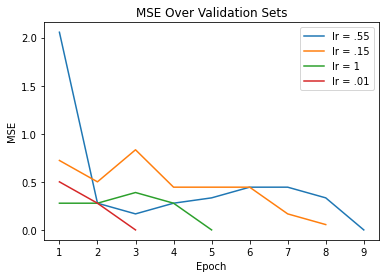

In [ ]:
plt.plot(epochs[0], mse_vals[0], label = 'lr = .55')
plt.plot(epochs[1], mse_vals[1], label = 'lr = .15')
plt.plot(epochs[2], mse_vals[2], label = 'lr = 1')
plt.plot(epochs[3], mse_vals[3], label = 'lr = .01')

plt.title('MSE Over Validation Sets')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()



In [ ]:
"""NOTE TO SELF: DON'T RERUN TAKES A LONG TIME."""
prev_acc = 0  # keeps track the previous accuracy
new_acc = 1
best_vals = []
best_trains = []
h_vals = []
test_acc = []
max_iterations = 10
h = 1

while np.abs(prev_acc - new_acc) > 1e-2:
  prev_acc = new_acc
  M =  MLPClassifier(momentum = .5, lr = .852, shuffle=True, validation=True, hidden_layer_widths = [h])
  M.fit(Xv,yv, max_iterations, Xv_val, yv_val, mse = True, score=True)
  new_acc = np.min(M.mse_val)
  best_vals.append(new_acc)
  best_trains.append(np.min(M.mse_train))

  test_acc.append(M.score(Xv_test, yvtest_hot))
  h_vals.append(h)
  h *= 2

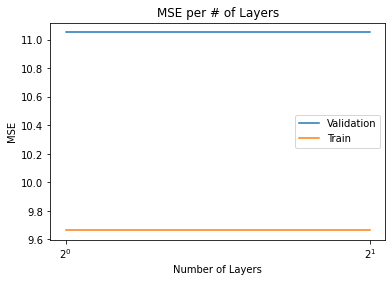

In [ ]:
plt.semilogx(h_vals, best_vals, basex = 2, label = 'Validation')
plt.semilogx(h_vals, best_trains, basex = 2, label = 'Train')
plt.xlabel('Number of Layers')
plt.ylabel('MSE')
plt.title('MSE per # of Layers')
plt.legend()
plt.show()

In [ ]:
prev_acc = 0  # keeps track the previous accuracy
new_acc = 1
best_vals = []
best_trains = []
h_vals = []
test_acc = []
max_iterations = 10
h = 1

while np.abs(prev_acc - new_acc) > 1e-2 and h < 16:
  prev_acc = new_acc
  M =  MLPClassifier(momentum = .5, lr = .852, shuffle=True, validation=True, hidden_layer_widths = [h])
  M.fit(Xi,yi, max_iterations, Xi_val, yi_val_hot, mse = True, score=True)
  new_acc = np.min(M.mse_val)
  print('diff', new_acc - prev_acc)
  best_vals.append(new_acc)
  best_trains.append(np.min(M.mse_train))

  test_acc.append(M.score(Xi_test, yitest_hot))
  h_vals.append(h)
  h *= 2

In [ ]:
print(test_acc)

[0.8333333333333334, 0.625, 0.7916666666666666]


In [ ]:
"""NOTE TO SELF: TAKES LONG TIME TO RUN DON'T RERUN."""
prev_acc = 0  # keeps track the previous accuracy
new_acc = 1
epochs = []
m_vals = []
test_acc = []
max_iterations = 100
m = .125

for i in range(5):
  prev_acc = new_acc
  M =  MLPClassifier(momentum = m, lr = .852, shuffle=True, validation=True, hidden_layer_widths = [4])
  M.fit(Xi,yi, max_iterations, Xi_val, yi_val_hot, mse = True, score=True)
  epochs.append(M.num_epochs)
  test_acc.append(M.score(Xi_test, yitest_hot))
  m_vals.append(m)
  m *= 2

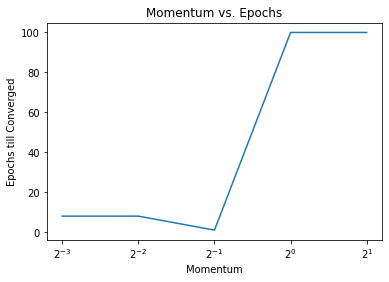

In [ ]:
plt.semilogx(m_vals, epochs, basex = 2)
plt.xlabel('Momentum')
plt.ylabel('Epochs till Converged')
plt.title('Momentum vs. Epochs')
plt.show()

In [ ]:
# comparing with built-in sklearn propagation
# Load sklearn perceptron, Vowel dataset
P = BackProp(hidden_layer_sizes=100, activation='relu', learning_rate_init=.01)
P.fit(Xv, yv)
print('Vowel score:', P.score(Xv_test, yv_test))

#Load sklearn perceptron, Iris dataset
P = BackProp(hidden_layer_sizes=5, activation='relu', learning_rate_init=.1)
P.fit(Xi, yi)
print('Iris score:', P.score(Xi_test, yi_test))

Vowel score: 0.9402173913043478
Iris score: 0.9523809523809523


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
